In [1]:
import os

# home_dir = '/content/gdrive/My Drive/AChina' 
# home_dir = '/hy-tmp'
# os.chdir(home_dir)
# pwd

!pip install tqdm 
!pip install fire

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import os
import warnings
import sys

import fire

# warnings.filterwarnings("ignore")  # avoid printing out absolute paths

# os.chdir("../../..")

!pip install scipy
!pip install torch 
!pip install pytorch_lightning==1.9.0 pytorch_forecasting

import copy
from pathlib import Path
import warnings

import time

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAPE, SMAPE, PoissonLoss, QuantileLoss, RMSE, MAE
from matplotlib import pyplot as plt
from pytorch_lightning.utilities.model_summary import summarize
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, StochasticWeightAveraging
from matplotlib import pyplot as plt

from multiprocessing import Pool, freeze_support

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
home_dir = '/hy-tmp'        
os.chdir(home_dir)

!pwd

# !ls

pl.seed_everything(1234, workers=True)

# from google.colab import drive
# drive.mount('/content/gdrive/')

# !ls

# home_dir = '/content/gdrive/My Drive/AChina'        
# os.chdir(home_dir)
# !pwd

/hy-tmp


Global seed set to 1234


1234

In [3]:
# data = np.load('A0mod_A0cr[rice]-yr[2005_2010_2017]-en[A0_RMSE_cyclic]-bs[128]-lr[0.01]_predict.npz')
# data = np.load('A0mod_A0cr[rice]-yr[2005_2010_2017]-en[A0_RMSE_cyclic]-bs[128]-lr[0.01]_test.npz')
data = np.load('A0Bmod_A0Bcr[rice]-yr[2005_2010_2017]-en[A0B]-bs[128]-lr[0.01]_predict_.npz')
data = np.load('A0Bmod_A0Bcr[rice]-yr[2005_2010_2017]-en[A0B]-bs[128]-lr[0.01]_test_.npz')
checkpoint = np.load('A0Bcr[rice]-yr[2005_2010_2017]-en[A0B]-bs[128]-lr[0.01]_.ckpt')

for ks in data.keys():
    print(ks)


actuals
predictions
prediction
encoder_target
decoder_target


In [4]:
# from A0B import ModelBase

# def train_TFT(exp_name, 
#               crop_name='rice', 
#               predicted_years="2004 2010 2017",
#               batch_size=16,
#               learning_rate=0.0325,
#               loss_func_metric='RMSE', 
#               max_epochs=100):

#     # print('predicted year:', predicted_years, type(predicted_years))

#     # torch.set_float32_matmul_precision('medium')

#     log_file = os.path.join('/hy-tmp', f'Log-cr[{crop_name}]-yr[{predicted_years}]-en[{exp_name}]-bs[{batch_size}].log')

# #         if os.path.exists(log_file):
# #             print(f'log file {log_file} exist')
# #             sys.exit(0)

# #         sys.stdout = Logger(log_file)

#     model = ModelBase(exp_name=exp_name, 
#                       predicted_years=predicted_years,
#                       max_epochs=max_epochs, 
#                       batch_size=batch_size, 
#                       learning_rate=learning_rate,
#                       loss_func_metric=loss_func_metric)

#     # model.init_lr_finder()
#     # model.custom_finder()
#     # model.train()
#     # model.predict()
#     model.test()
#     model.inference()
#     # model.plot_predict()
#     print('The end...')
#     sys.exit(0)
    
# train_TFT(exp_name='a0_fix_data_val')

In [5]:
print(data['prediction'].shape, data['encoder_target'].shape, data['decoder_target'].shape)
print( np.asarray(data['prediction'][0,0,0]) )
print( np.asarray(data['prediction'][0]) )

(81, 16, 1) (81, 18) (81, 16)
0.6803716
[[0.6803716 ]
 [0.67616606]
 [0.67710817]
 [0.67768323]
 [0.6744453 ]
 [0.67566735]
 [0.6754828 ]
 [0.6764545 ]
 [0.6732195 ]
 [0.6756236 ]
 [0.67402613]
 [0.67090523]
 [0.6730884 ]
 [0.67416894]
 [0.6738227 ]
 [0.67823696]]


In [6]:
MOD_BINS = 128
FAM_BINS = 64
datasetfile = f'data/ALIM{MOD_BINS}F{FAM_BINS}DATASET_rice.csv'
alidata = pd.read_csv(os.path.join(home_dir,datasetfile))

alidata.head()

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,month,MOD_month_t,time_idx,Unnamed: 0.1.1.1,county,year,b0b0,...,Wind_f_tavg_53,Wind_f_tavg_54,Wind_f_tavg_55,Wind_f_tavg_56,Wind_f_tavg_57,Wind_f_tavg_58,Wind_f_tavg_59,Wind_f_tavg_60,Wind_f_tavg_61,Wind_f_tavg_62
0,0,0,0,1,0,0,0,0,2003,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0,1,1,1,0,0,2003,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,0,1,2,2,0,0,2003,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3,0,2,0,3,0,0,2003,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,0,2,1,4,0,0,2003,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4, 5]


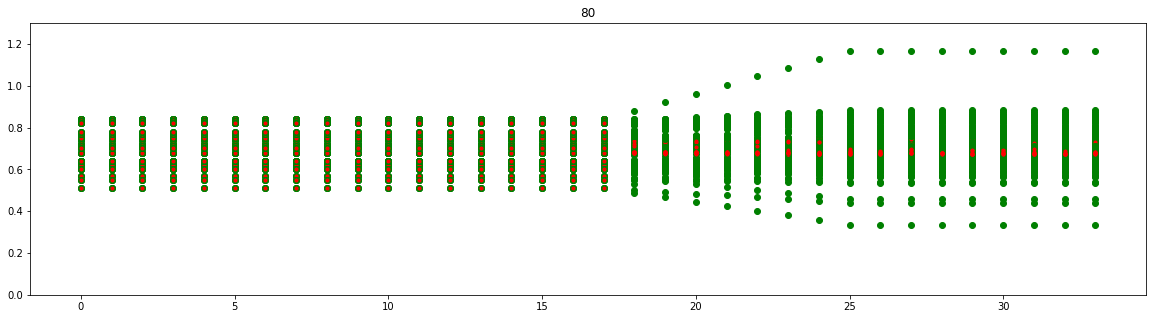

In [9]:
samples = [X for X in range(data['prediction'].shape[0])]

X = [X for X in range(0,5)]

# X = [X for X in range(data['encoder_target'][0:10])]

print(X)

X.append(len(X))

print(X)

files = [1,]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5)) 
for sample in samples:
    # data = np.load(ifile)

    # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5)) 
    
    Y = np.array([])
    Y_= np.array([])
    
    Y = np.concatenate( (Y, np.asarray(data['encoder_target'][sample][...])) )
    Y_= np.concatenate( (Y_, np.asarray(data['encoder_target'][sample][...])) )
    
    # print(Y.shape)
    # fn

    # Y = np.asarray(data['decoder_target'][sample][...]) 
    # Y_ = np.asarray(data['prediction'][sample,...,0]) 
    
    Y = np.concatenate( (Y, np.asarray(data['decoder_target'][sample][...])) ) 
    Y_ = np.concatenate((Y_, np.asarray(data['prediction'][sample,...,0])) ) 
    
    # print(county, Y)
    # print(Y_)
    X = [X for X in range(len(Y))]
    ax.plot(np.asarray(X), np.asarray(Y), 'o', color='green')
    ax.plot(np.asarray(X), np.asarray(Y_), '.', color='red')
    ax.set(title=sample)
plt.ylim([0, 1.3])
plt.show()

# for ifile in files:
#     # data = np.load(ifile)
    
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5)) 
#     for county in counties:
#         Y = np.asarray(data['decoder_target'][county][0]) 
#         Y_ = np.asarray(data['prediction'][county,0,0]) 
#         # print(county, Y)
#         # print(Y_)
#         ax.plot(np.asarray(county), np.asarray(Y), 'o', color='green')
#         ax.plot(np.asarray(county), np.asarray(Y_), '.', color='red')
#         ax.set(title=ifile)
#     plt.ylim([0, 1.3])
#     plt.show()

In [8]:
fn

NameError: name 'fn' is not defined